In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [2]:
file_path = '/content/SAMSUNG.csv'

# Đọc dữ liệu từ file CSV
df = pd.read_csv(file_path, index_col='Date', parse_dates=True)

In [3]:
df

,Close,Open,High,Low
Date,,,,
2019-03-04,44850,46000,46100,44800
2019-03-05,44250,44600,45100,44150
2019-03-06,44000,44000,44300,43700
2019-03-07,44450,43400,44950,43400
2019-03-08,43800,44450,44800,43800
...,...,...,...,...
2024-05-21,78400,78500,79000,78200
2024-05-22,77700,78100,78700,77300
2024-05-23,78300,77700,79100,77100


In [4]:
# Định nghĩa hàm kiểm tra tính dừng
def check_stationarity(data):
    for col in data.columns:
        result = adfuller(data[col])
        print(f'Kiểm tra tính dừng cho cột {col}:')
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print(f'Critical Values:')
        for key, value in result[4].items():
            print(f'   {key}: {value}')
        print(f'==> {"Không phải" if result[1] > 0.05 else "Là"} chuỗi dừng\n')

# Gọi hàm kiểm tra tính dừng với DataFrame của bạn
check_stationarity(df)

Kiểm tra tính dừng cho cột Close:
ADF Statistic: -1.7258398182876133
p-value: 0.41785059734984886
Critical Values:
   1%: -3.4346228529495666
   5%: -2.8634272008756785
   10%: -2.5677747177787733
==> Không phải chuỗi dừng

Kiểm tra tính dừng cho cột Open:
ADF Statistic: -1.7277725964438515
p-value: 0.41686298071854583
Critical Values:
   1%: -3.4346284441307184
   5%: -2.863429668579316
   10%: -2.5677760318409732
==> Không phải chuỗi dừng

Kiểm tra tính dừng cho cột High:
ADF Statistic: -1.7928582671289763
p-value: 0.384013086051204
Critical Values:
   1%: -3.4346368583924454
   5%: -2.8634333822589966
   10%: -2.5677780093918754
==> Không phải chuỗi dừng

Kiểm tra tính dừng cho cột Low:
ADF Statistic: -1.8129126216437594
p-value: 0.37407004144528466
Critical Values:
   1%: -3.4346228529495666
   5%: -2.8634272008756785
   10%: -2.5677747177787733
==> Không phải chuỗi dừng



In [5]:
from sklearn.model_selection import train_test_split

# chia bộ dữ liệu theo tỉ lệ 6:4
train, test = train_test_split(df, test_size=0.4, shuffle=False)

# dùng diff để chuyển đổi bộ dữ liệu
train_diff = train.diff()
train_diff.dropna(inplace = True)

In [6]:
# Định nghĩa hàm kiểm tra tính dừng
def check_stationarity(data):
    for col in data.columns:
        result = adfuller(data[col])
        print(f'Kiểm tra tính dừng cho cột {col}:')
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print(f'Critical Values:')
        for key, value in result[4].items():
            print(f'   {key}: {value}')
        print(f'==> {"Không phải" if result[1] > 0.05 else "Là"} chuỗi dừng\n')

# Gọi hàm kiểm tra tính dừng với DataFrame của bạn
check_stationarity(train_diff)

Kiểm tra tính dừng cho cột Close:
ADF Statistic: -9.394986478678266
p-value: 6.410078140749421e-16
Critical Values:
   1%: -3.4374934418959495
   5%: -2.8646935508856495
   10%: -2.568449150231867
==> Là chuỗi dừng

Kiểm tra tính dừng cho cột Open:
ADF Statistic: -9.591473319712787
p-value: 2.030608452912225e-16
Critical Values:
   1%: -3.4374934418959495
   5%: -2.8646935508856495
   10%: -2.568449150231867
==> Là chuỗi dừng

Kiểm tra tính dừng cho cột High:
ADF Statistic: -6.394654847609881
p-value: 2.0650617849238807e-08
Critical Values:
   1%: -3.4375723382479735
   5%: -2.8647283387229963
   10%: -2.568467680189796
==> Là chuỗi dừng

Kiểm tra tính dừng cho cột Low:
ADF Statistic: -6.125484219487879
p-value: 8.649804662695214e-08
Critical Values:
   1%: -3.4375803238413085
   5%: -2.8647318597670877
   10%: -2.568469555703587
==> Là chuỗi dừng



In [7]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.0 MB/s eta 0:00:00


In [8]:
from pmdarima import auto_arima
import pandas as pd
pq = []
for column in train_diff:
    print(f'Searching order of p and q for : {column}')
    stepwise_model = auto_arima(train_diff[column],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)

    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{column} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Close
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=15262.082, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15258.171, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=15260.092, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=15260.101, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=15259.510, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.412 seconds
optimal order for:Close is: (0, 0, 0) 


Searching order of p and q for : Open
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=15413.431, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15410.645, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=15411.977, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=15411.955, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=15412.149, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
To

In [9]:

model = VARMAX(train_diff, order=(1, 1))
results = model.fit()

print(results.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                  Statespace Model Results                                  
Dep. Variable:     ['Close', 'Open', 'High', 'Low']   No. Observations:                  927
Model:                                   VARMA(1,1)   Log Likelihood              -28376.381
                                        + intercept   AIC                          56844.762
Date:                              Sun, 02 Jun 2024   BIC                          57067.032
Time:                                      14:02:46   HQIC                         56929.551
Sample:                                           0                                         
                                              - 927                                         
Covariance Type:                                opg                                         
Ljung-Box (L1) (Q):     0.25, 0.81, 0.01, 0.29   Jarque-Bera (JB):   648.50, 304.15, 8943.78, 1543.17
Prob(Q):                0.62, 0.37, 0.91, 0.59   Prob(JB):   

In [10]:
predict = results.get_prediction(start = len(train), end = len(train) + len(test) - 1)
predicts = predict.predicted_mean

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [11]:
predicts.columns = ['Open_predicted', 'High_predicted', 'Low_predicted', 'Close_predicted']
predicts['Date'] = test.index
predicts
predicts_date = predicts.set_index('Date')
predicts_date

,Open_predicted,High_predicted,Low_predicted,Close_predicted
Date,,,,
2022-04-20,45.483444,50.490826,59.243936,123.857868
2022-04-21,25.660331,33.636791,36.180211,23.085650
2022-04-22,30.484372,25.167282,29.090373,29.488629
2022-04-24,30.244874,28.389053,30.481064,31.199114
2022-04-25,30.204133,28.025387,30.489316,30.928311
...,...,...,...,...
2024-05-21,30.208959,28.030607,30.467607,30.921274
2024-05-22,30.208959,28.030607,30.467607,30.921274
2024-05-23,30.208959,28.030607,30.467607,30.921274


In [12]:
# Lấy giá trị cuối cùng của dữ liệu gốc trước khi diff
last_original_values = df.iloc[len(train)-1]


# Lấy giá trị cuối cùng của dữ liệu gốc trước khi diff
last_original_values = df.iloc[-len(test) - 1]
# Tạo một DataFrame để chứa các giá trị dự đoán gốc
forecast_original_data = pd.DataFrame(columns=['Open', 'High', 'Low', 'Close'], index=test.index)

# Khởi tạo giá trị bắt đầu với giá trị cuối cùng của dữ liệu gốc
current_values = last_original_values.copy()

# Thực hiện inverse differencing cho từng ngày dự đoán
for index, row in predicts_date.iterrows():
    current_values['Open'] += row['Open_predicted']
    current_values['High'] += row['High_predicted']
    current_values['Low'] += row['Low_predicted']
    current_values['Close'] += row['Close_predicted']
    # Thêm giá trị hiện tại vào DataFrame kết quả
    forecast_original_data.loc[index] = current_values

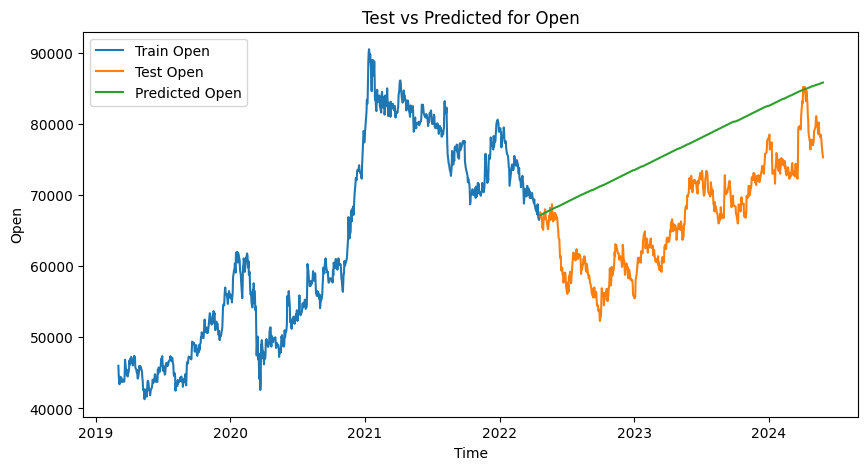

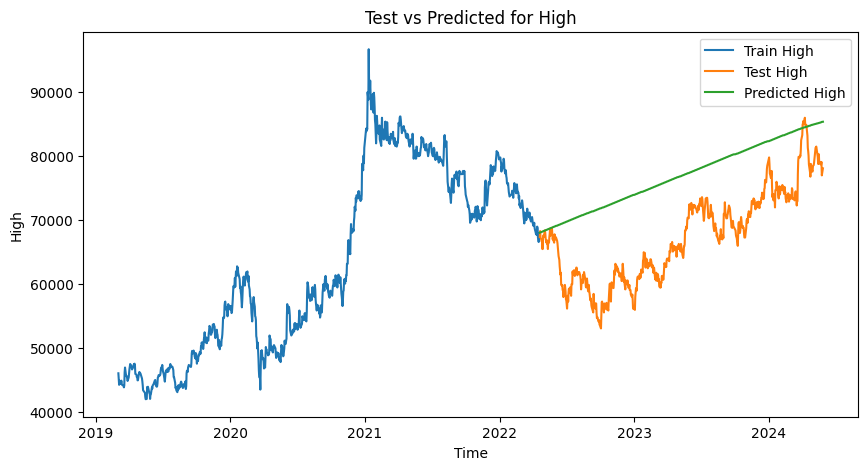

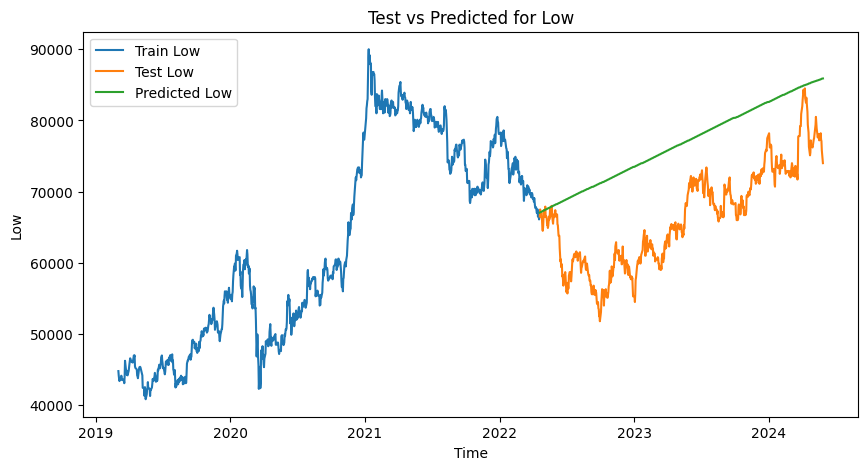

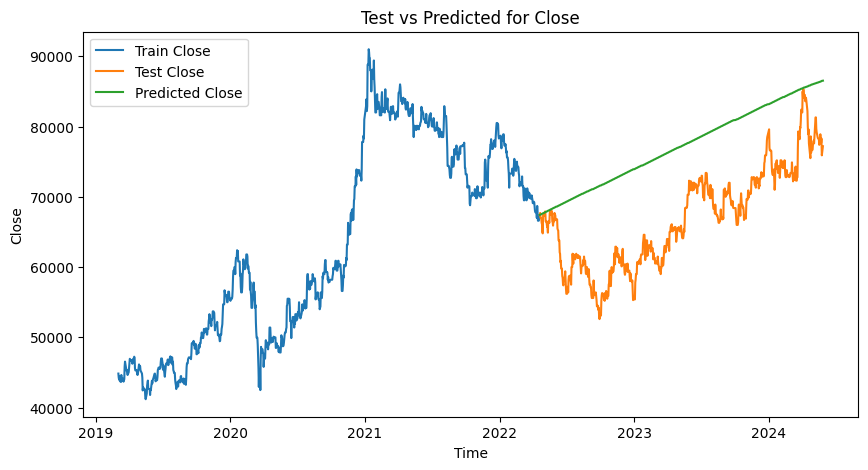

In [13]:
# Vẽ biểu đồ cho mỗi cặp cột
for col in ['Open', 'High', 'Low', 'Close']:
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train[col], label=f'Train {col}')
    plt.plot(test.index, test[col], label=f'Test {col}')
    plt.plot(forecast_original_data.index, forecast_original_data[col], label=f'Predicted {col}')
    plt.title(f'Test vs Predicted for {col}')
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.legend()
    plt.show()

In [14]:


# Tính toán MAPE và RMSE
mape = mean_absolute_percentage_error(test, predicts_date)
rmse = np.sqrt(mean_squared_error(test, predicts_date))
mse = mean_squared_error(test, predicts_date)
r2 = r2_score(test, predicts_date)

print(f'MAPE: {mape:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MSE: {mse:.4f}')
print(f'R²: {r2:.4f}')

results_GBM = pd.DataFrame([['Gradient Boosting', mape, mse, rmse, r2]],
               columns = ['Model', 'MAE', 'MSE', 'RMSE', 'R2 Score'])
results_GBM

MAPE: 0.9995
RMSE: 66977.6255
MSE: 4486002320.3212
R²: -95.4737


,Model,MAE,MSE,RMSE,R2 Score
0,Gradient Boosting,0.999546,4.486002e+09,66977.62552,-95.4737
